# Code to map postcodes to shp files

## May - June 2020

#### Postcode definition file (version 2020May) downloaded from UK Data Service https://borders.ukdataservice.ac.uk/pcluts.html

##### Downloaded: 13 June 2020 (Previous 19 May 2020)
##### Version: 2020may (Previous 2020feb)

##### Column names are due to change in May 2020 version.

## Import libraries

In [4]:
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import epydemiology as epy
import geopandas as gpd
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point

## Deal with postcode data

### Load csv file into dataframe

In [6]:
# CSV files don't contain headers. The names of the column headings are stored
# in a file called Code-Point_Open_Column_Headers.csv. Retrieve list of columns from file.
#phjPathToDoc = './data/postcode/onspd/pcluts_2020feb'
#phjFilename = '/ONSPD_FEB_2020_UK.csv'

phjPathToDoc = './data/postcode/onspd/pcluts_2020may'
phjFilename = '/ONSPD_MAY_2020_UK.csv'

phjPostcodeDF = pd.read_csv(Path('/'.join([phjPathToDoc,phjFilename])))

print(phjPostcodeDF.dtypes)
print('\n')
print(phjPostcodeDF)

/Users/philipjones/opt/anaconda3/envs/geo-env37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,31,40,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


pcd           object
pcd2          object
pcds          object
dointr         int64
doterm       float64
oscty         object
ced           object
oslaua        object
osward        object
parish        object
usertype       int64
oseast1m     float64
osnrth1m     float64
osgrdind       int64
oshlthau      object
nhser         object
ctry          object
rgn           object
streg         object
pcon          object
eer           object
teclec        object
ttwa          object
pct           object
nuts          object
statsward     object
oa01          object
casward       object
park          object
lsoa01        object
msoa01        object
ur01ind       object
oac01         object
oa11          object
lsoa11        object
msoa11        object
wz11          object
ccg           object
bua11         object
buasd11       object
ru11ind       object
oac11         object
lat          float64
long         float64
lep1          object
lep2          object
pfa           object
imd          

In [7]:
phjPostcodeDF = phjPostcodeDF[['pcd','pcd2','pcds','ctry','oseast1m','osnrth1m','lat','long']].copy()

print(phjPostcodeDF.dtypes)
print('\n')
print(phjPostcodeDF)

pcd          object
pcd2         object
pcds         object
ctry         object
oseast1m    float64
osnrth1m    float64
lat         float64
long        float64
dtype: object


             pcd      pcd2     pcds       ctry  oseast1m   osnrth1m  \
0        AB1 0AA  AB1  0AA  AB1 0AA  S92000003  385386.0   801193.0   
1        AB1 0AB  AB1  0AB  AB1 0AB  S92000003  385177.0   801314.0   
2        AB1 0AD  AB1  0AD  AB1 0AD  S92000003  385053.0   801092.0   
3        AB1 0AE  AB1  0AE  AB1 0AE  S92000003  384600.0   799300.0   
4        AB1 0AF  AB1  0AF  AB1 0AF  S92000003  384460.0   800660.0   
...          ...       ...      ...        ...       ...        ...   
2643723  ZE3 9JW  ZE3  9JW  ZE3 9JW  S92000003  438975.0  1110038.0   
2643724  ZE3 9JX  ZE3  9JX  ZE3 9JX  S92000003  438872.0  1110219.0   
2643725  ZE3 9JY  ZE3  9JY  ZE3 9JY  S92000003  438498.0  1112029.0   
2643726  ZE3 9JZ  ZE3  9JZ  ZE3 9JZ  S92000003  438662.0  1112122.0   
2643727  ZE3 9XP  ZE3  9XP  ZE3 9XP  S92000

### Convert to geodataframe

#### Example (choose one or other method below, either oseast1m/osnrth1m or long/lat)

File contains both longitude ('long') and latitude ('lat'), and easting ('oseast1m') and northing ('osnrth1m') columns. The longitude and latitude points use WGS84 (espg 4326) whilst the easting and northing points use OSGB96 projection (espg 27700) for GB postcodes and (presumably) epsg 2157 for points in Northern Ireland (see below). Either of these columns could be used to create a geometry and converted between the two crs systems. As an example, in the following cell the 'long' and 'lat' columns are converted to a point geometry (with epsg = 4326) in a geopandas geodataframe and the crs converted to epsg 27700.


CRS used in Ireland

EPSG:29901 OSNI 1952 / Irish National Grid. Not used in Republic of Ireland. Replaced in 1975 by TM75 / Irish Grid (CRS code 29903) (see https://epsg.io/29901)

EPSG:29902 TM65 / Irish Grid -- Ireland. Not used in Northern Ireland. Replaced by TM75 / Irish Grid (code 29903) in 1975 (see https://epsg.io/29902)

EPSG:29903 TM75 / Irish Grid. Replaces both OSNI 1952 / Irish National Grid (code 29901) and TM65 / Irish Grid (code 29902) from 1975. Replaced by IRENET95 / Irish Transverse Mercator (code 2157) from 1/1/2001. (see https://epsg.io/29903)

EPSG:2157 IRENET95 / Irish Transverse Mercator Replaces TM75 / Irish Grid (code 29903) from 1/1/2001. (see https://epsg.io/2157)

##### Create geodataframe containing easting and northing data only

In [8]:
phjPostcodeGDF = gpd.GeoDataFrame(phjPostcodeDF.drop(['oseast1m', 'osnrth1m'], axis = 1),
                                  crs = {'init': 'epsg:27700'},
                                  geometry = [Point(xy) for xy in zip(phjPostcodeDF['oseast1m'],
                                                                      phjPostcodeDF['osnrth1m'])])

# Newer version of geopandas may use
#phjPostcodeGDF = gpd.GeoDataFrame(phjPostcodeDF,
#                                  crs={'init': 'epsg:4326'},
#                                  geometry=gpd.points_from_xy(phjPostcodeDF['EA'],
#                                                              phjPostcodeDF['NO']))

print('CRS')
print('---')
print(phjPostcodeGDF.crs)
print('\n')
print('GeoPandas DataFrame with postcode point geometry')
print('------------------------------------------------')
print(phjPostcodeGDF)

CRS
---
{'init': 'epsg:27700'}


GeoPandas DataFrame with postcode point geometry
------------------------------------------------
             pcd      pcd2     pcds       ctry        lat      long  \
0        AB1 0AA  AB1  0AA  AB1 0AA  S92000003  57.101474 -2.242851   
1        AB1 0AB  AB1  0AB  AB1 0AB  S92000003  57.102554 -2.246308   
2        AB1 0AD  AB1  0AD  AB1 0AD  S92000003  57.100556 -2.248342   
3        AB1 0AE  AB1  0AE  AB1 0AE  S92000003  57.084444 -2.255708   
4        AB1 0AF  AB1  0AF  AB1 0AF  S92000003  57.096656 -2.258102   
...          ...       ...      ...        ...        ...       ...   
2643723  ZE3 9JW  ZE3  9JW  ZE3 9JW  S92000003  59.873651 -1.305697   
2643724  ZE3 9JX  ZE3  9JX  ZE3 9JX  S92000003  59.875286 -1.307502   
2643725  ZE3 9JY  ZE3  9JY  ZE3 9JY  S92000003  59.891572 -1.313847   
2643726  ZE3 9JZ  ZE3  9JZ  ZE3 9JZ  S92000003  59.892392 -1.310899   
2643727  ZE3 9XP  ZE3  9XP  ZE3 9XP  S92000003  59.887104 -1.307578   

                

In [9]:
print(phjPostcodeGDF.dtypes)
print('\n')
print(phjPostcodeGDF['ctry'].value_counts())

pcd          object
pcd2         object
pcds         object
ctry         object
lat         float64
long        float64
geometry     object
dtype: object


E92000001    2204583
S92000003     225028
W92000004     139331
N92000002      61794
L93000001       6950
M83000003       6042
Name: ctry, dtype: int64


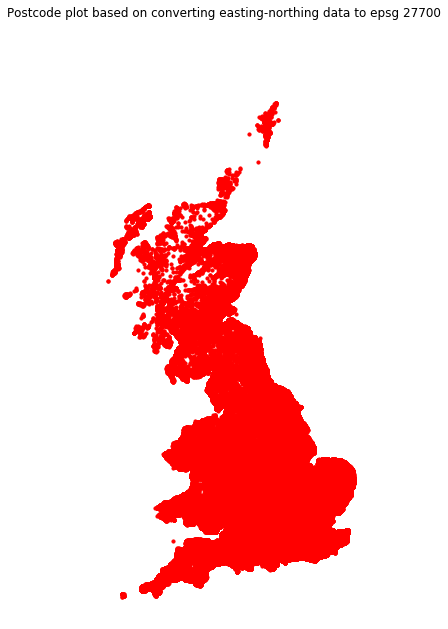

In [10]:
# Plot postcode points
# --------------------

fig, ax = plt.subplots(1,
                       figsize = (8,10))

ax.set_axis_off()

phjPostcodeGDF.plot(ax = ax,
                    color = 'red',
                    markersize = 10)

fig.suptitle('Postcode plot based on converting easting-northing data to epsg 27700')

plt.show()

##### Create geodataframe containing longitude and latitude data only

N.B. this cell replaces phjPostcodeGDF created in previous cell.

In [11]:
# Create a point geometry and drop the original 'long' and 'lat' columns
#phjPostcodeGDF = gpd.GeoDataFrame(phjPostcodeDF.drop(['long', 'lat'], axis = 1),
#                                  crs = {'init': 'epsg:4326'},
#                                  geometry = [Point(xy) for xy in zip(phjPostcodeDF['long'],
#                                                                      phjPostcodeDF['lat'])])

# Create a point geometry and retain the original 'long' and 'lat' columns
phjPostcodeGDF = gpd.GeoDataFrame(phjPostcodeDF,
                                  crs = {'init': 'epsg:4326'},
                                  geometry = [Point(xy) for xy in zip(phjPostcodeDF['long'],
                                                                      phjPostcodeDF['lat'])])



# Newer version of geopandas may use
#phjPostcodeGDF = gpd.GeoDataFrame(phjPostcodeDF,
#                                  crs={'init': 'epsg:4326'},
#                                  geometry=gpd.points_from_xy(phjPostcodeDF['EA'],
#                                                              phjPostcodeDF['NO']))

phjPostcodeGDF = phjPostcodeGDF.to_crs(epsg=27700)

print('CRS')
print('---')
print(phjPostcodeGDF.crs)
print('\n')
print('GeoPandas DataFrame with postcode point geometry')
print('------------------------------------------------')
print(phjPostcodeGDF)

CRS
---
{'init': 'epsg:27700', 'no_defs': True}


GeoPandas DataFrame with postcode point geometry
------------------------------------------------
             pcd      pcd2     pcds       ctry  oseast1m   osnrth1m  \
0        AB1 0AA  AB1  0AA  AB1 0AA  S92000003  385386.0   801193.0   
1        AB1 0AB  AB1  0AB  AB1 0AB  S92000003  385177.0   801314.0   
2        AB1 0AD  AB1  0AD  AB1 0AD  S92000003  385053.0   801092.0   
3        AB1 0AE  AB1  0AE  AB1 0AE  S92000003  384600.0   799300.0   
4        AB1 0AF  AB1  0AF  AB1 0AF  S92000003  384460.0   800660.0   
...          ...       ...      ...        ...       ...        ...   
2643723  ZE3 9JW  ZE3  9JW  ZE3 9JW  S92000003  438975.0  1110038.0   
2643724  ZE3 9JX  ZE3  9JX  ZE3 9JX  S92000003  438872.0  1110219.0   
2643725  ZE3 9JY  ZE3  9JY  ZE3 9JY  S92000003  438498.0  1112029.0   
2643726  ZE3 9JZ  ZE3  9JZ  ZE3 9JZ  S92000003  438662.0  1112122.0   
2643727  ZE3 9XP  ZE3  9XP  ZE3 9XP  S92000003  438854.0  1111535.0   


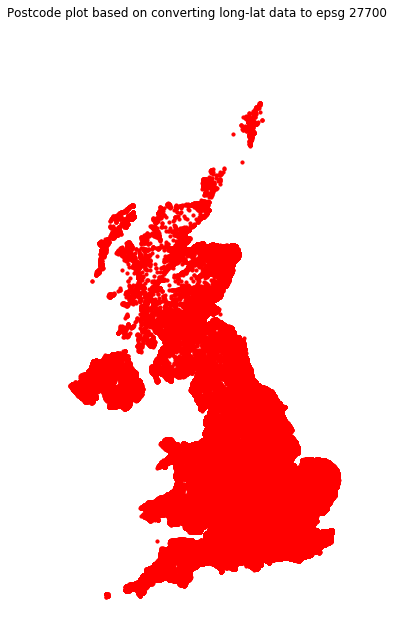

In [12]:
# Plot postcode points
# --------------------

fig, ax = plt.subplots(1,
                       figsize = (8,10))

ax.set_axis_off()

phjPostcodeGDF.plot(ax = ax,
                    color = 'red',
                    markersize = 10)

fig.suptitle('Postcode plot based on converting long-lat data to epsg 27700')

plt.show()

IMPORTANT NOTICE

There are 2 geographical variables included in the ONS postcode file, namely 'long' and 'lat', and 'oseast1m' and 'osnrth1m'. It is relatively easy to convert the long/lat data to epsg 27700 projection for plotting on a map as shown in the second map above. However, the easting/northing data cannot but used to plot data directly (even though, on first look, the data appears to be epsg 27700) because the data for postcodes in Northern Ireland use a different co-ordinate system (presumably epsg 2157). The results can be seen in the first map above where postcode points in Northern Ireland are plotted over North Wales and the Irish Sea.

### Remove postcodes from Northern Ireland (and IoM and Channel Islands)

Retain postcodes only from England, Wales and Scotland; exclude postcodes from Northern Ireland, Isle of Man and Channel Islands

In [13]:
# Read country codes from Country names and codes UK as at 08_12.csv

phjCtryDefPath = './data/postcode/onspd/pcluts_2020may/Documents'
phjCtryDefFilename = 'Country names and codes UK as at 08_12.csv'

phjCtryDefDF = pd.read_csv(Path('/'.join([phjCtryDefPath,phjCtryDefFilename])))

print(phjCtryDefDF)

    CTRY12CD  CTRY12CDO          CTRY12NM         CTRY12NMW
0  E92000001        921           England            Lloegr
1  N92000002        922  Northern Ireland  Gogledd Iwerddon
2  S92000003        923          Scotland          Yr Alban
3  W92000004        924             Wales             Cymru
4  L93000001        931   Channel Islands               NaN
5  M83000003        833       Isle of Man               NaN


In [14]:
# Create list of country codes
phjCtryCodesList = list(phjCtryDefDF.loc[phjCtryDefDF['CTRY12NM'].isin(['England','Scotland','Wales']),'CTRY12CD'])

print('List of country codes')
print('---------------------')
print(phjCtryCodesList)

List of country codes
---------------------
['E92000001', 'S92000003', 'W92000004']


In [15]:
# Retain Eng, Scot and Wal postcodes only
phjPostcodeGDF = phjPostcodeGDF[phjPostcodeGDF['ctry'].isin(phjCtryCodesList)].copy()

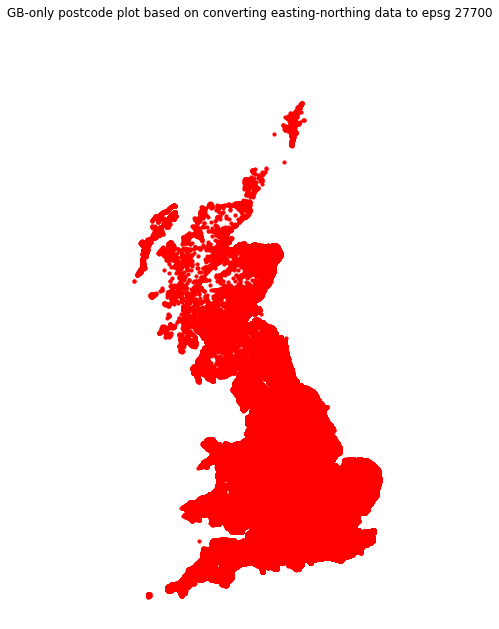

In [16]:
# Plot postcode points
# --------------------

fig, ax = plt.subplots(1,
                       figsize = (8,10))

ax.set_axis_off()

phjPostcodeGDF.plot(ax = ax,
                    color = 'red',
                    markersize = 10)

fig.suptitle('GB-only postcode plot based on converting easting-northing data to epsg 27700')

plt.show()

### Print postcodes where long/lat data is missing

In [17]:
print('Postcodes with missing long/lat data')
print('------------------------------------')
print(phjPostcodeGDF.loc[(phjPostcodeGDF['long'].isnull()) |
                         (phjPostcodeGDF['lat'].isnull()),:])

Postcodes with missing long/lat data
------------------------------------
Empty GeoDataFrame
Columns: [pcd, pcd2, pcds, ctry, oseast1m, osnrth1m, lat, long, geometry]
Index: []


### Remove unnecessary columns

In [18]:
phjPostcodeGDF = phjPostcodeGDF[['pcd','geometry']].copy()

print(phjPostcodeGDF)

             pcd                                     geometry
0        AB1 0AA  POINT (385386.0200145852 801192.9668666961)
1        AB1 0AB  POINT (385177.0154930766 801313.9439800865)
2        AB1 0AD  POINT (385052.9809068323 801091.9736495648)
3        AB1 0AE  POINT (384599.9809451913 799300.0382340769)
4        AB1 0AF  POINT (384460.0227725373 800660.0223669789)
...          ...                                          ...
2643723  ZE3 9JW   POINT (438974.9905737375 1110037.96107858)
2643724  ZE3 9JX  POINT (438872.0260470185 1110218.985083678)
2643725  ZE3 9JY  POINT (438498.0057608088 1112028.981142908)
2643726  ZE3 9JZ  POINT (438662.0252881918 1112122.012767859)
2643727  ZE3 9XP  POINT (438854.0175564135 1111535.051691643)

[2568942 rows x 2 columns]


## Deal with shape file county boundary definitions

##### There are 2 shp files commonly used in the SEDA group that define: i) county boundaries that are used by CPH numbers (more or less); and ii) county boundaries used to display results

### i. Open .shp file containing definitions of county boundaries used by CPH numbers

Shape file opened in GeoPandas.

In [19]:
phjPathToShp = './data/shp/CountyCPH_SPIDA'
phjShpFilename = 'CountyCPH_SPIDA.shp'

phjCPHCountyShpGDF = gpd.read_file(Path('/'.join([phjPathToShp,phjShpFilename])))

print('Shape file defining county boundaries')
print('-------------------------------------')
print(phjCPHCountyShpGDF)
print('\n')
print('CRS of shape file')
print('-----------------')
print(phjCPHCountyShpGDF.crs)

Shape file defining county boundaries
-------------------------------------
    CTYID         CTY_Name    Shape_Leng    Shape_Area CTY_TXT  \
0       1     BEDFORDSHIRE  2.465263e+05  1.235430e+09      01   
1       2        BERKSHIRE  2.968358e+05  1.263888e+09      02   
2       3  BUCKINGHAMSHIRE  4.158884e+05  1.873592e+09      03   
3       4        CLEVELAND  1.856756e+05  6.166302e+08      04   
4       5   CAMBRIDGESHIRE  4.282122e+05  3.397450e+09      05   
..    ...              ...           ...           ...     ...   
85     94         SHETLAND  1.633179e+06  1.464483e+09      94   
86     95         STIRLING  3.019841e+05  1.200410e+09      95   
87     96       SUTHERLAND  8.748082e+05  5.438952e+09      96   
88     97     WEST LOTHIAN  1.185830e+05  3.203769e+08      97   
89     98          WIGTOWN  2.859029e+05  1.269581e+09      98   

                                             geometry  
0   POLYGON ((505548.5937999999 270000.0933999997,...  
1   POLYGON ((48942

#### Plot county boundaries

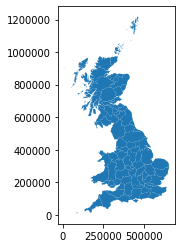

In [20]:
phjCPHCountyShpGDF.plot()

#### Example of changing the shapefile CRS

It is easy to change the CRS of the shape file if required.

In [21]:
#phjCPHCountyShpGDF = phjCPHCountyShpGDF.to_crs(epsg=4326)

#phjCPHCountyShpGDF.plot()

#### Example of plotting individual points on map of county boundaries

In [22]:
phjExamplePostcodeList = ['CH5 4HE','NP4 5DG','CH647TE','W1A 1AA','KT153NB']

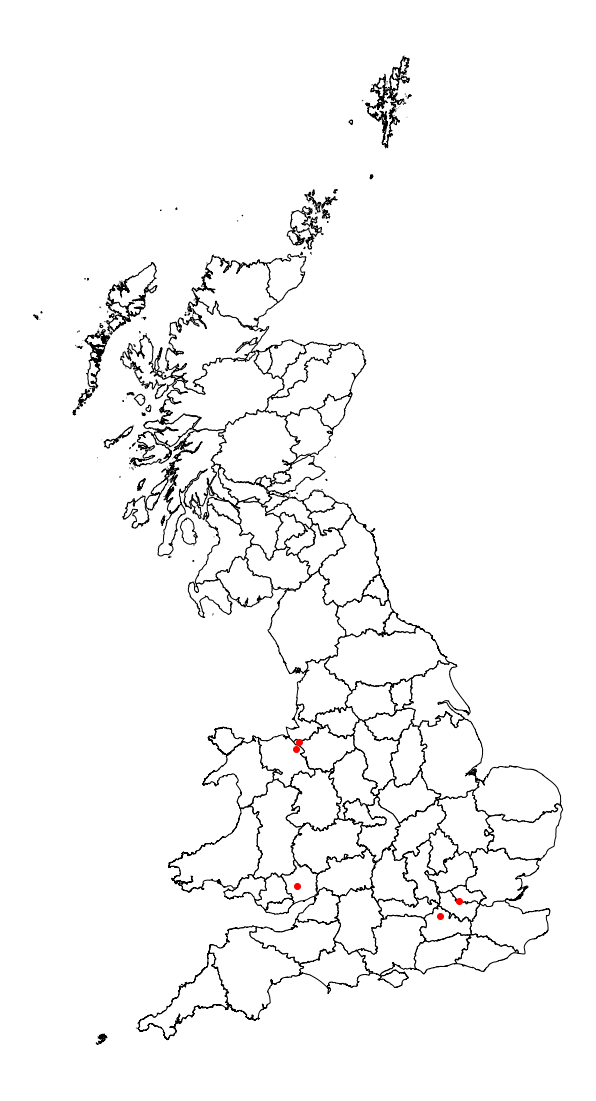

In [23]:
fig, ax = plt.subplots(1,
                       figsize = (16,20))

ax = phjCPHCountyShpGDF.plot(ax = ax,
                             color = 'white',
                             edgecolor = 'black')

ax.set_axis_off()

phjPostcodeGDF[phjPostcodeGDF['pcd'].isin(phjExamplePostcodeList)].plot(ax = ax,
                                                                       color = 'red')

plt.show()

#### Spatial join postcode geodataframe with county shapefile geodataframe to produce dataframe that links postcode with CPHCounty names

In [24]:
phjPostcodeCPHCountyGDF = gpd.sjoin(phjPostcodeGDF[['pcd','geometry']],
                                    phjCPHCountyShpGDF[['CTYID','CTY_Name','geometry']],
                                    op = 'within',
                                    how = 'left')

# Remove the column entitled 'index_right'
phjPostcodeCPHCountyGDF = phjPostcodeCPHCountyGDF[[c for c in phjPostcodeCPHCountyGDF if c not in ['index_right']]].rename(columns = {'CTYID':'CPH_CTYID',
                                                                                                                                      'CTY_Name':'CPH_CTY_Name'}).copy()

print('Postcode-CPHCounty lookup table')
print('-------------------------------')
print(phjPostcodeCPHCountyGDF)

/Users/philipjones/opt/anaconda3/envs/geo-env37/lib/python3.7/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


Postcode-CPHCounty lookup table
-------------------------------
             pcd                                     geometry  CPH_CTYID  \
0        AB1 0AA  POINT (385386.0200145852 801192.9668666961)       66.0   
1        AB1 0AB  POINT (385177.0154930766 801313.9439800865)       66.0   
2        AB1 0AD  POINT (385052.9809068323 801091.9736495648)       66.0   
3        AB1 0AE  POINT (384599.9809451913 799300.0382340769)       80.0   
4        AB1 0AF  POINT (384460.0227725373 800660.0223669789)       66.0   
...          ...                                          ...        ...   
2643723  ZE3 9JW   POINT (438974.9905737375 1110037.96107858)       94.0   
2643724  ZE3 9JX  POINT (438872.0260470185 1110218.985083678)       94.0   
2643725  ZE3 9JY  POINT (438498.0057608088 1112028.981142908)       94.0   
2643726  ZE3 9JZ  POINT (438662.0252881918 1112122.012767859)       94.0   
2643727  ZE3 9XP  POINT (438854.0175564135 1111535.051691643)       94.0   

            CPH_CTY_Nam

#### Check example postcodes are in the correct county

In [25]:
print(phjPostcodeCPHCountyGDF[phjPostcodeCPHCountyGDF['pcd'].isin(phjExamplePostcodeList)])

             pcd                                     geometry  CPH_CTYID  \
454425   CH5 4HE  POINT (328805.0369567781 368499.0085549916)       56.0   
458868   CH647TE   POINT (331601.0045824968 377450.967810317)        6.0   
1142933  KT153NB  POINT (504989.3875341495 162686.8237957761)       40.0   
1616015  NP4 5DG  POINT (328928.9711537863 199951.9980981813)       60.0   
2457778  W1A 1AA  POINT (528887.0145308574 181592.9591395249)       26.0   

                  CPH_CTY_Name  
454425                   CLWYD  
458868                CHESHIRE  
1142933                 SURREY  
1616015                  GWENT  
2457778  GREATER LONDON - EAST  


### ii. Open .shp file containing county definitions used to report SIU outputs

In [26]:
pwd

'/Users/philipjones/Documents/git_repositories/cartograpy'

In [27]:
phjPathToShp = './data/shp/County2000'
phjShpFilename = 'County2000.shp'

phjCounty2000ShpGDF = gpd.read_file(Path('/'.join([phjPathToShp,phjShpFilename])))

print('Shape file defining county boundaries')
print('-------------------------------------')
print(phjCounty2000ShpGDF)
print('\n')
print('CRS of shape file')
print('-----------------')
print(phjCounty2000ShpGDF.crs)

Shape file defining county boundaries
-------------------------------------
    OBJECTID_1      REGION IDENTITY                    CORRECT_CO  \
0            1    Scotland      SHT                      Shetland   
1            2    Scotland      ORK                        Orkney   
2            3    Scotland     HIGH                     Highlands   
3            4    Scotland       EA               Eileanan an lar   
4            5    Scotland      NES        North Eastern Scotland   
..         ...         ...      ...                           ...   
63          64  South East      SXW                   West Sussex   
64          65  South East      SXE                   East Sussex   
65          66  South West     DORS                        Dorset   
66          67  South West   CORNIS  Cornwall and Isles of Scilly   
67          68  South East      IOW                 Isle of Wight   

      Shape_Leng    Shape_Area  \
0   1.258084e+06  1.410668e+09   
1   7.191927e+05  9.579071e

#### Spatial join postcode geodataframe with county shapefile geodataframe to produce dataframe that links postcode with County2000 names

In [28]:
phjPostcodeCounty2000GDF = gpd.sjoin(phjPostcodeGDF[['pcd','geometry']],
                                     phjCounty2000ShpGDF[['OBJECTID_1','IDENTITY','CORRECT_CO','geometry']],
                                     op = 'within',
                                     how = 'left')

# Remove the column entitled 'index_right'
phjPostcodeCounty2000GDF = phjPostcodeCounty2000GDF[[c for c in phjPostcodeCounty2000GDF if c not in ['index_right']]].rename(columns = {'OBJECTID_1':'CTY2000_OBJECTID',
                                                                                                                                         'IDENTITY':'CTY2000_IDENTITY',
                                                                                                                                         'CORRECT_CO':'CTY2000_CORRECT_CO'}).copy()

print('Postcode-County2000 lookup table')
print('-------------------------------')
print(phjPostcodeCounty2000GDF)

Postcode-County2000 lookup table
-------------------------------
             pcd                                     geometry  \
0        AB1 0AA  POINT (385386.0200145852 801192.9668666961)   
1        AB1 0AB  POINT (385177.0154930766 801313.9439800865)   
2        AB1 0AD  POINT (385052.9809068323 801091.9736495648)   
3        AB1 0AE  POINT (384599.9809451913 799300.0382340769)   
4        AB1 0AF  POINT (384460.0227725373 800660.0223669789)   
...          ...                                          ...   
2643723  ZE3 9JW   POINT (438974.9905737375 1110037.96107858)   
2643724  ZE3 9JX  POINT (438872.0260470185 1110218.985083678)   
2643725  ZE3 9JY  POINT (438498.0057608088 1112028.981142908)   
2643726  ZE3 9JZ  POINT (438662.0252881918 1112122.012767859)   
2643727  ZE3 9XP  POINT (438854.0175564135 1111535.051691643)   

         CTY2000_OBJECTID CTY2000_IDENTITY      CTY2000_CORRECT_CO  
0                     5.0              NES  North Eastern Scotland  
1               

## Combine postcode-county dataframes

#### In original version, 'geometry' column removed but subsequently decided that needed to be able to plot unmapped values therefore decided to retain 'geometry' column

In [29]:
#phjPostcodeCountyDF = pd.merge(phjPostcodeCPHCountyGDF[[c for c in phjPostcodeCPHCountyGDF if c not in ['geometry']]],
#                               phjPostcodeCounty2000GDF[[c for c in phjPostcodeCounty2000GDF if c not in ['geometry']]],
#                               on = 'pcd')

phjPostcodeCountyGDF = pd.merge(phjPostcodeCPHCountyGDF,
                                phjPostcodeCounty2000GDF[[c for c in phjPostcodeCounty2000GDF if c not in ['geometry']]],
                                on = 'pcd')


print(phjPostcodeCountyGDF)

             pcd                                     geometry  CPH_CTYID  \
0        AB1 0AA  POINT (385386.0200145852 801192.9668666961)       66.0   
1        AB1 0AB  POINT (385177.0154930766 801313.9439800865)       66.0   
2        AB1 0AD  POINT (385052.9809068323 801091.9736495648)       66.0   
3        AB1 0AE  POINT (384599.9809451913 799300.0382340769)       80.0   
4        AB1 0AF  POINT (384460.0227725373 800660.0223669789)       66.0   
...          ...                                          ...        ...   
2568937  ZE3 9JW   POINT (438974.9905737375 1110037.96107858)       94.0   
2568938  ZE3 9JX  POINT (438872.0260470185 1110218.985083678)       94.0   
2568939  ZE3 9JY  POINT (438498.0057608088 1112028.981142908)       94.0   
2568940  ZE3 9JZ  POINT (438662.0252881918 1112122.012767859)       94.0   
2568941  ZE3 9XP  POINT (438854.0175564135 1111535.051691643)       94.0   

            CPH_CTY_Name  CTY2000_OBJECTID CTY2000_IDENTITY  \
0          ABERDEENSHIRE

#### Check example postcodes have the correct county definitions

In [30]:
print(phjPostcodeCountyGDF[phjPostcodeCountyGDF['pcd'].isin(phjExamplePostcodeList)])

             pcd                                     geometry  CPH_CTYID  \
392631   CH5 4HE  POINT (328805.0369567781 368499.0085549916)       56.0   
397074   CH647TE   POINT (331601.0045824968 377450.967810317)        6.0   
1068147  KT153NB  POINT (504989.3875341495 162686.8237957761)       40.0   
1541229  NP4 5DG  POINT (328928.9711537863 199951.9980981813)       60.0   
2382992  W1A 1AA  POINT (528887.0145308574 181592.9591395249)       26.0   

                  CPH_CTY_Name  CTY2000_OBJECTID CTY2000_IDENTITY  \
392631                   CLWYD              31.0              WNE   
397074                CHESHIRE              30.0             CHES   
1068147                 SURREY              60.0             SURR   
1541229                  GWENT              54.0               WS   
2382992  GREATER LONDON - EAST              55.0             GLON   

        CTY2000_CORRECT_CO  
392631    North East Wales  
397074            Cheshire  
1068147             Surrey  
1541229     

In [31]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    print(phjPostcodeCountyGDF['CTY2000_CORRECT_CO'].value_counts(dropna = False))

Greater London                               322237
Greater Manchester                           112716
West Yorkshire                                87934
Hampshire                                     86077
West Midlands                                 85075
South Wales                                   84861
Kent                                          68962
Essex                                         65923
Clyde Valley                                  65259
Merseyside                                    58718
Lancashire                                    55885
Devon                                         52891
Hertfordshire                                 52868
Surrey                                        52369
Northern Somerset & South Gloucestershire     50869
South Yorkshire                               47039
Cheshire                                      46783
Berkshire                                     45918
North Yorkshire                               44869
Derbyshire  

## Postcodes with missing county definitions

### County2000 definitions only

In [32]:
print(phjPostcodeCountyGDF.loc[phjPostcodeCountyGDF['CTY2000_CORRECT_CO'].isnull(),:])

             pcd                                     geometry  CPH_CTYID  \
658      AB1 2LH   POINT (394244.0088348587 804909.945632331)        NaN   
682      AB1 2NP  POINT (394560.9902686733 806025.9483270934)        NaN   
685      AB1 2NS  POINT (394632.0122007368 805964.9605813839)        NaN   
692      AB1 2PB  POINT (394782.0045195636 805947.9545388974)        NaN   
695      AB1 2PG   POINT (395268.0082716304 805804.975261542)        NaN   
...          ...                                          ...        ...   
2568921  ZE2 9YJ  POINT (447759.0228027315 1141280.033198756)        NaN   
2568922  ZE2 9YL  POINT (417319.9984648917 1159961.984633486)       94.0   
2568923  ZE2 9YN  POINT (447759.0228027315 1141280.033198756)        NaN   
2568925  ZE2 9YQ  POINT (447759.0228027315 1141280.033198756)        NaN   
2568927  ZE2 9YZ  POINT (417319.9984648917 1159961.984633486)       94.0   

        CPH_CTY_Name  CTY2000_OBJECTID CTY2000_IDENTITY CTY2000_CORRECT_CO  
658       

### Both CPH County and County2000 definitions

In [33]:
print(phjPostcodeCountyGDF.loc[(phjPostcodeCountyGDF['CPH_CTY_Name'].isnull()) |
                               (phjPostcodeCountyGDF['CTY2000_CORRECT_CO'].isnull()),:])

             pcd                                     geometry  CPH_CTYID  \
658      AB1 2LH   POINT (394244.0088348587 804909.945632331)        NaN   
682      AB1 2NP  POINT (394560.9902686733 806025.9483270934)        NaN   
685      AB1 2NS  POINT (394632.0122007368 805964.9605813839)        NaN   
692      AB1 2PB  POINT (394782.0045195636 805947.9545388974)        NaN   
695      AB1 2PG   POINT (395268.0082716304 805804.975261542)        NaN   
...          ...                                          ...        ...   
2568921  ZE2 9YJ  POINT (447759.0228027315 1141280.033198756)        NaN   
2568922  ZE2 9YL  POINT (417319.9984648917 1159961.984633486)       94.0   
2568923  ZE2 9YN  POINT (447759.0228027315 1141280.033198756)        NaN   
2568925  ZE2 9YQ  POINT (447759.0228027315 1141280.033198756)        NaN   
2568927  ZE2 9YZ  POINT (417319.9984648917 1159961.984633486)       94.0   

        CPH_CTY_Name  CTY2000_OBJECTID CTY2000_IDENTITY CTY2000_CORRECT_CO  
658       

### Add column to indicate with either or both county definitions are null

In [34]:
phjPostcodeCountyGDF['nullCounty'] = 'neither_null'

phjPostcodeCountyGDF.loc[(phjPostcodeCountyGDF['CPH_CTY_Name'].isnull()) &
                         (phjPostcodeCountyGDF['CTY2000_CORRECT_CO'].notnull()),'nullCounty'] = 'cph_cty_name_only_null'

phjPostcodeCountyGDF.loc[(phjPostcodeCountyGDF['CPH_CTY_Name'].notnull()) &
                         (phjPostcodeCountyGDF['CTY2000_CORRECT_CO'].isnull()),'nullCounty'] = 'cty2000_correct_co_only_null'

phjPostcodeCountyGDF.loc[(phjPostcodeCountyGDF['CPH_CTY_Name'].isnull()) &
                         (phjPostcodeCountyGDF['CTY2000_CORRECT_CO'].isnull()),'nullCounty'] = 'both_null'

print('Number of postcodes not mapped to county defintions')
print('---------------------------------------------------')
print(phjPostcodeCountyGDF['nullCounty'].value_counts())

Number of postcodes not mapped to county defintions
---------------------------------------------------
neither_null                    2560075
both_null                          8392
cty2000_correct_co_only_null        461
cph_cty_name_only_null               14
Name: nullCounty, dtype: int64


### Print postcodes with missing county

In [35]:
print('Postcodes with missing CPH county definitions only')
print('--------------------------------------------------')
print(phjPostcodeCountyGDF.loc[phjPostcodeCountyGDF['nullCounty'].eq('cph_cty_name_only_null'),:])
print('\n')

print('Postcodes with missing County2000 definition only')
print('-------------------------------------------------')
print(phjPostcodeCountyGDF.loc[phjPostcodeCountyGDF['nullCounty'].eq('cty2000_correct_co_only_null'),:])

Postcodes with missing CPH county definitions only
--------------------------------------------------
             pcd                                     geometry  CPH_CTYID  \
538567   DD109LT  POINT (370498.0229625081 758964.0196144655)        NaN   
801226   G1  5HN  POINT (259387.8886462794 664557.4939007263)        NaN   
1039906  IV201RX  POINT (285984.8325008964 882321.4163459589)        NaN   
1670115  PA437LN  POINT (132446.9970847932 660384.9689535213)        NaN   
1935838  SA152AJ  POINT (250549.9929256979 198403.9769665352)        NaN   
1935842  SA152AQ  POINT (250507.0101978319 198467.0213153738)        NaN   
1935869  SA152BZ  POINT (250588.0107610101 198435.0164486032)        NaN   
1935873  SA152DE  POINT (250794.0309664661 198111.0504710287)        NaN   
1935874  SA152DF    POINT (250821.0248164948 197993.94519753)        NaN   
1935876  SA152DH  POINT (250546.0111775717 198334.9781779692)        NaN   
1935877  SA152DJ   POINT (250595.4926811049 198334.737064735) 

### Plot missing postcodes

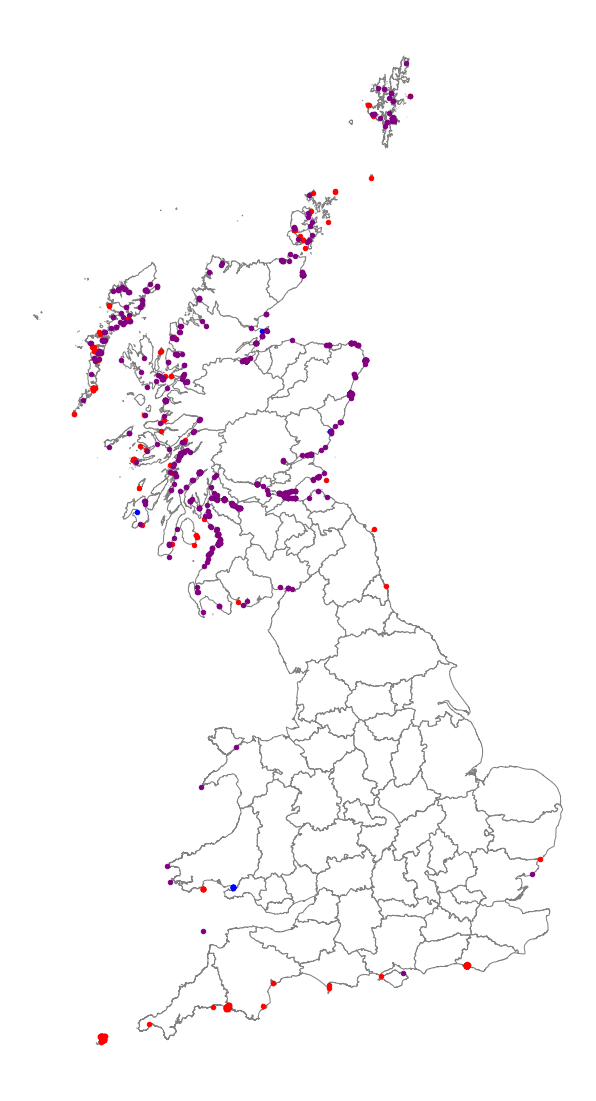

In [36]:
fig, ax = plt.subplots(1,
                       figsize = (16,20))

ax = phjCPHCountyShpGDF.plot(ax = ax,
                             color = 'white',
                             edgecolor = 'gray')

ax.set_axis_off()

phjPostcodeCountyGDF.loc[phjPostcodeCountyGDF['nullCounty'].eq('cty2000_correct_co_only_null'),['pcd','geometry']].plot(ax = ax,
                                                                                                                   color = 'red',
                                                                                                                       markersize = 20)

phjPostcodeCountyGDF.loc[phjPostcodeCountyGDF['nullCounty'].eq('cph_cty_name_only_null'),['pcd','geometry']].plot(ax = ax,
                                                                                                             color = 'blue',
                                                                                                             markersize = 20)

phjPostcodeCountyGDF.loc[phjPostcodeCountyGDF['nullCounty'].eq('both_null'),['pcd','geometry']].plot(ax = ax,
                                                                                                color = 'purple',
                                                                                                markersize = 20)

plt.show()

## Write to CSV file

In [37]:
phjPathToCSV = '.'
phjCSVFilename = 'ONSPDPostcodeToShpCounties.csv'

phjPostcodeCountyGDF[[c for c in phjPostcodeCountyGDF if c not in ['geometry']]].to_csv(Path('/'.join([phjPathToCSV,phjCSVFilename])),
                           index = False)

print('Done')

Done
